## Intro

Debug datasets preprocessing steps.

In [42]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

In [4]:
%run ./iu_xray.py

In [5]:
reports_dir = os.path.join(DATASET_DIR, 'reports')

## Load data

In [6]:
reports_fname = os.path.join(reports_dir, 'reports.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3955, 3955)

In [28]:
info_fname = os.path.join(DATASET_DIR, 'info.json')
with open(info_fname, 'r') as f:
    info = json.load(f)
len(info)

2

In [65]:
with open(info_fname, 'w') as f:
    json.dump(info, f)

### Rotate images

In [55]:
rotations = [
    ('left', -90),
    ('right', 90),
    ('bottom', 180),
]

In [ ]:
for key, degrees in rotations:
    images_key = f'rotated_{key}'
    for image_name in info['marks'][images_key]:
        filepath = os.path.join(DATASET_DIR, 'images', image_name)
        img = Image.open(filepath).rotate(degrees)
        # img.save(filepath)

## Clean text

### Tokenize and clean

In [15]:
import re

In [16]:
# NUMBER_TOKEN = 'NUMBER'

In [17]:
def text_to_tokens(text):
    text = text.lower()
    text = re.sub(r'(;|,+)', r',', text)
    
    # text = re.sub(r'\d+\.\d+', NUMBER_TOKEN, text)
    # text = re.sub(r'\d+(nd|th)?', NUMBER_TOKEN, text)
    
    text = re.sub(r'< ?br ?\?>', ' ', text)
    text = re.sub(r'[\[\]<>]', '', text)
    text = re.sub(r'(\(|\))', r' \1 ', text)
    
    text = re.sub(r'\.+', r'.', text)
    text = re.sub(r'([a-zA-Z])(\.|,|/)', r'\1 \2', text)
    text = re.sub(r'(\.|,|/)([a-zA-Z])', r'\1 \2', text)
    
    return text.split()

In [19]:
IGNORE_TOKENS = set(['p.m.'])
token_appearances = dict()
errors = {
    'findings-none': [],
    'impression-none': [],
    'text-none': [],
    'no-images': [],
}

cleaned_reports_as_dict = dict()

for report in reports:
    filename = report['filename']
    findings = report['findings']
    impression = report['impression']

    n_images = len(report['images'])
    if n_images == 0:
        errors['no-images'].append(filename)
        continue
    
    text = findings
    if findings is None and impression is None:
        errors['text-none'].append(filename)
        continue
    elif findings is None:
        errors['findings-none'].append(filename)
        text = impression
    elif impression is None:
        errors['impression-none'].append(filename)

    # Clean and tokenize text
    tokens = [token for token in text_to_tokens(text) if token not in IGNORE_TOKENS]

    for token in tokens:
        if token not in token_appearances:
            token_appearances[token] = 0
        token_appearances[token] += 1

    cleaned_report = {k: v for k, v in report.items()}
    cleaned_report['clean_text'] = ' '.join(tokens)

    cleaned_reports_as_dict[filename] = cleaned_report

print({k: len(v) for k, v in errors.items()})
print(len(token_appearances))
len(cleaned_reports_as_dict), len(reports)

{'findings-none': 489, 'impression-none': 6, 'text-none': 25, 'no-images': 104}
1923


(3826, 3955)

In [20]:
len([k for k, v in token_appearances.items() if v > 1])

1299

In [21]:
sorted([(k, v) for k, v in token_appearances.items() if re.search(r'[()]', k)],
       key=lambda x:x[1], reverse=False)

[(')', 13), ('(', 14)]

### Review errors

In [142]:
reports_as_dict[errors['no-images'][0]]

{'comparison': 'None',
 'filename': '1068.xml',
 'findings': 'Heart size and pulmonary vascularity are within normal limits. No focal infiltrate, pneumothorax or pleural effusion is identified.',
 'images': [],
 'impression': 'No active disease.',
 'indication': 'Chest congestion',
 'tags_auto': [],
 'tags_manual': ['normal']}

### Review specific tokens

In [92]:
found = []

for report in reports:
    name = report['filename']
    text = report['findings']
    
    if text is None:
        continue
        
    s = re.search('[\[\]><]', text)
    if s and 'and/or' not in text:
        found.append((name, text)) # s.group(0)

print(len(found))
found

3


[('2192.xml',
  'No focal lung consolidation. No pneumothorax or pleural effusion.Heart size and pulmonary vascularity are within normal limits.Minimal degenerative changes of the thoracic spine. The previously<BR>described XXXX deformity in the midthoracic spine is again seen. There is subcutaneous shunt catheter tubing along the anterior chest wall'),
 ('2513.xml',
  '[<Heart size and pulmonary vascularity within normal limits. There is a large hiatal hernia seen projecting in the retrocardiac region. This is XXXX from prior examination. There is associated atelectasis in the left lung base. No pleural effusion or pneumothorax is identified.'),
 ('2542.xml',
  'The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiomediastinal contours are within normal limits. [Pulmonary vascularity is within normal limits>]. No focal consolidation, pleural effusion, or pneumothorax identified. The visualized osseous structures and upper abdomen are unremarkable.')]

### Save cleaned reports

In [22]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'w') as f:
    json.dump(cleaned_reports_as_dict, f)

## Add side to image info (in cleaned reports)

`side` can be one of (`frontal`, `lateral-left`, `lateral-right`)

In [66]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = json.load(f)
len(clean_reports)

3826

In [75]:
wrong_images = set(info['marks']['wrong'])
broken_images = set(info['marks']['broken'])

In [79]:
for report_name, report_dict in clean_reports.items():
    new_images_info = []
    for image_info in report_dict['images']:
        image_name = image_info['id']
        image_name = f'{image_name}.png'

        image_info['side'] = info['classification'][image_name]
        image_info['wrong'] = image_name in wrong_images
        image_info['broken'] = image_name in broken_images

        new_images_info.append(image_info)
    
    report_dict['images'] = new_images_info
    clean_reports[report_name] = report_dict
    
len(clean_reports)

3826

## Calculate image normalization

In [86]:
import torch
from tqdm.notebook import tqdm

In [88]:
image_folder = os.path.join(DATASET_DIR, 'images')

In [89]:
image_names = os.listdir(image_folder)
image_names = [i for i in image_names if i.endswith('.png')]
len(image_names)

7470

In [90]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [93]:
summed = torch.zeros(3, 256, 256)

for image_name in tqdm(image_names):
    fpath = os.path.join(image_folder, image_name)
    image = transform(Image.open(fpath).convert('RGB'))
    summed += image
    
summed /= len(image_names)

In [94]:
summed.mean(dim=-1).mean(dim=-1)

tensor([0.4822, 0.4822, 0.4822])

In [95]:
summed.std(dim=-1).std(dim=-1)

tensor([0.0461, 0.0461, 0.0461])

## Test `IUXrayDataset` class

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

In [4]:
%run ./iu_xray.py

In [5]:
dataset = IUXRayDataset(max_images=None)
dataset.size()

(7430, 3826)

In [6]:
len(dataset.word_to_idx)

1881

In [9]:
image, report = dataset[0]
image.size()

torch.Size([3, 624, 512])

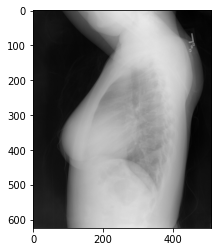

In [10]:
plt.imshow(image.numpy().transpose(1, 2, 0))

### Review different image shapes

In [205]:
shapes = set()

for idx in range(len(dataset)):
    image, _ = dataset[idx]
    shapes.add(image.numpy().shape)

len(shapes)

251

In [206]:
shapes

{(3, 378, 512),
 (3, 391, 512),
 (3, 392, 512),
 (3, 399, 512),
 (3, 403, 512),
 (3, 409, 512),
 (3, 413, 512),
 (3, 415, 512),
 (3, 419, 512),
 (3, 420, 512),
 (3, 421, 512),
 (3, 422, 512),
 (3, 423, 512),
 (3, 424, 512),
 (3, 425, 512),
 (3, 426, 512),
 (3, 428, 512),
 (3, 429, 512),
 (3, 430, 512),
 (3, 431, 512),
 (3, 433, 512),
 (3, 434, 512),
 (3, 435, 512),
 (3, 436, 512),
 (3, 437, 512),
 (3, 441, 512),
 (3, 442, 512),
 (3, 443, 512),
 (3, 446, 512),
 (3, 447, 512),
 (3, 448, 512),
 (3, 449, 512),
 (3, 450, 512),
 (3, 451, 512),
 (3, 454, 512),
 (3, 456, 512),
 (3, 457, 512),
 (3, 459, 512),
 (3, 460, 512),
 (3, 461, 512),
 (3, 462, 512),
 (3, 463, 512),
 (3, 464, 512),
 (3, 466, 512),
 (3, 467, 512),
 (3, 468, 512),
 (3, 469, 512),
 (3, 470, 512),
 (3, 471, 512),
 (3, 472, 512),
 (3, 473, 512),
 (3, 474, 512),
 (3, 475, 512),
 (3, 476, 512),
 (3, 478, 512),
 (3, 479, 512),
 (3, 480, 512),
 (3, 481, 512),
 (3, 482, 512),
 (3, 483, 512),
 (3, 484, 512),
 (3, 485, 512),
 (3, 486

### Load single images

In [11]:
fname = DATASET_DIR + '/images/CXR5_IM-2117-1003002.png'
img = Image.open(fname)
img_tensor = transforms.ToTensor()(img)
img.size, img_tensor.size()

((512, 621), torch.Size([3, 621, 512]))